<a href="https://colab.research.google.com/github/mancinimassimiliano/DeepLearningLab/blob/master/Lab5/anime_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks (GAN) 

GAN consists of a generator network and a discriminator network. The generator network is in charge of generating synthetic images from noise to fool the discriminator. On the other hand, the discriminator network is in charge of telling apart real images from fake images. This leads to a two player mini-max adversarial game between the two. Through this optimization, the generator learns to produce photo-realistic images, similar to the real data.

In this lab session we will learn how to code a GAN to generate anime faces from noise!

In [0]:
# import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.optim as optim
from torchvision.utils import save_image

Add the [tar](https://drive.google.com/file/d/1GTmSp3Bz-LTjTI3cj5x0VOl4NFkJmyYp/view?usp=sharing) to your gdrive and then extract the files from the tar (see below). Please change the paths according to your directory structure of gdrive.

In [13]:
% cd /content/sample_data/

/content/sample_data


In [0]:
# Specify the path of the tar in your gdrive
% cp "/content/drive/My Drive/Colab Notebooks/anime-faces.tar.gz" ./

In [0]:
# extract the images from the tar file
! tar -xvf anime-faces.tar.gz

In [0]:
# Declare some constants

img_size = 64
root_folder = "/content/sample_data/anime-faces"
batch_size = 128
nc = 3 # number of channels in an image (RGB)
ngf = 64 # number of features in the generator
ndf = 64 # number of channels in the discriminator
nz = 100 # dimension of the latent space
lr = 0.0002 # learning rate for the networks
num_epochs = 100 # total number of training epochs
save_dir = "/content/sample_data/gan_log/"

We will visualize some samples from the dataset.

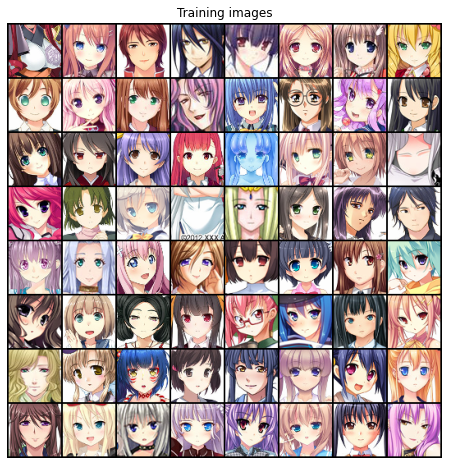

In [15]:
# create a set of transforms for the dataset
dset_transforms = list()
dset_transforms.append(transforms.Resize(img_size))
dset_transforms.append(transforms.ToTensor())
dset_transforms.append(transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                            std=[0.5, 0.5, 0.5]))
dset_transforms = transforms.Compose(dset_transforms)

# create a dataset using ImageFolder of pytorch
dataset = dset.ImageFolder(root=root_folder, transform=dset_transforms)

# create a data loader
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=4,
                        shuffle=True, drop_last=True)

# Plot images
fixed_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(vutils.make_grid(fixed_batch[0][:64], padding=2, 
                                         normalize=True), (1, 2, 0)))

In [0]:
# custom weight initialization on the netG and netD
def weight_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0.0)

In [0]:
# define the generator. Its a DCGAN-like generator.

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.main = nn.Sequential(
        nn.ConvTranspose2d(in_channels=nz, out_channels=ngf * 8,
                           kernel_size=(4, 4), stride=1, padding=0,
                           bias=False),
        nn.BatchNorm2d(num_features=ngf * 8),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(in_channels=ngf * 8, out_channels=ngf * 4,
                           kernel_size=(4, 4), stride=2, padding=1,
                           bias=False),
        nn.BatchNorm2d(num_features=ngf * 4),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(in_channels=ngf * 4, out_channels=ngf * 2,
                           kernel_size=(4, 4), stride=2, padding=1,
                           bias=False),
        nn.BatchNorm2d(num_features=ngf * 2),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(in_channels=ngf * 2, out_channels=ngf,
                           kernel_size=(4, 4), stride=2, padding=1,
                           bias=False),
        nn.BatchNorm2d(num_features=ngf),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(in_channels=ngf, out_channels=nc,
                           kernel_size=(4, 4), stride=2, padding=1,
                           bias=False),
        nn.Tanh()
    )
  
  def forward(self, x):
    out = self.main(x)
    return out 

In [18]:
netG = Generator().cuda()
netG.apply(weight_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [0]:
# define the discriminator

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.main = nn.Sequential(
        nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=(4, 4),
                  stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(in_channels=ndf, out_channels=ndf * 2, kernel_size=(4, 4),
                  stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(in_channels=ndf * 2, out_channels=ndf * 4, kernel_size=(4, 4),
                  stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(in_channels=ndf * 4, out_channels=ndf * 8, kernel_size=(4, 4),
                  stride=2, padding=1, bias=False),
        nn.BatchNorm2d(num_features=ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(in_channels=ndf * 8, out_channels=1, kernel_size=(4, 4),
                  stride=1, padding=0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, x):
    out = self.main(x)
    return out

In [20]:
netD = Discriminator().cuda()
netD.apply(weight_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [0]:
# define the loss criterion
criterion = nn.BCELoss()

# sample a fixed noise vector that will be used to visualize the training
# progress
fixed_noise = torch.randn(64, nz, 1, 1).cuda()

# define the ground truth labels.
real_labels = 1 # for the real images
fake_labels = 0 # for the fake images

# define the optimizers, one for each network
netD_optimizer = optim.Adam(params=netD.parameters(), lr=lr, betas=(0.5, 0.999))
netG_optimizer = optim.Adam(params=netG.parameters(), lr=lr, betas=(0.5, 0.999))

# sample two fixed noise vectors and do a linear interpolation between them
# to get the intermediate noise vectors. We will generate samples for the interpolated
# noise vectors to see effect of interpolation in the latent space. (See later!)
z_1 = torch.randn(1, nz, 1, 1)
z_2 = torch.randn(1, nz, 1, 1)
fixed_interpolate = []
for i in range(64):
  lambda_interp = i / 63
  z_interp = z_1 * (1 - lambda_interp) + lambda_interp * z_2
  fixed_interpolate.append(z_interp)
fixed_interpolate = torch.cat(fixed_interpolate, dim=0).cuda()

In [0]:
def main():
  # Training loop
  iters = 0

  # for each epoch
  for epoch in range(num_epochs):
    # iterate through the data loader
    for i, data in enumerate(dataloader, 0):
      
      ## Discriminator training ##
      # maximize log(D(x)) + log(1 - D(G(x)))

      # The discriminator will be updated once with the real images
      # and once with the fake images. This is achieved by first computing
      # the gradients with the real images (the first term in the D loss function),
      # and then with the fake images generated by the G (second loss term).
      # Only after that the optimizer.step() will be done, which will update the
      # weights of the D.
      # IMPORTANT to note that when the D is updated, the G is kept frozen.
      # Gradients are calculated with loss.backward().

      # train D with real images
      netD.train()
      netD.zero_grad()
      real_images = data[0].cuda()
      bs = real_images.shape[0]
      label = torch.full((bs,), real_labels).cuda() 
      output = netD(real_images).view(-1)
      # calculate loss on real images. It pushes the D's output for real images
      # close to 1
      errD_real = criterion(output, label)
      # calculate gradients for D
      errD_real.backward()
      # track D outputs for real images
      D_x = output.mean().item()

      # train D with fake images
      # sample a batch of noise vectors
      noise = torch.randn(bs, nz, 1, 1).cuda()
      # generate fake data
      fake_images = netG(noise)
      label.fill_(fake_labels)
      # run the fake images through the discriminator. 
      # IMPORTANT to detach the fake_images because we do not need gradients
      # of the G activations wrt to the G weights.
      output = netD(fake_images.detach()).view(-1)
      # calculate loss on the fake images. It pushes the D's output for fake
      # images close to 0
      errD_fake = criterion(output, label)
      # calculate the gradients for D
      errD_fake.backward()
      errD = (errD_real + errD_fake)
      # track D outputs for fake images
      D_G_x_1 = output.mean().item()

      # update the D weights with the gradients accumulated
      netD_optimizer.step()

      ## Generator training ##
      # minimize log(1 - D(G(x)))
      # But such a formulation provides no gradient during the early stages of
      # training and hence its is reformulated as:
      # maximize log(D(G(x)))

      # during the G training the D is kept fixed
      netG.train()
      netG.zero_grad()
      # real_labels because the G wants to make the fake images look as real as 
      # possible
      label.fill_(real_labels)
      output = netD(fake_images).view(-1)
      # calculate loss for G based on the fake images. It pushes the D's output
      # for fake images close to 1
      errG = criterion(output, label)
      # calculate the gradients for G
      errG.backward()
      # track the outputs for fake images
      D_G_x_2 = output.mean().item()

      # update the G weights with the gradients accumulated
      netG_optimizer.step()

      # print the training losses
      if iters % 100 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % (epoch, 
            num_epochs, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_x_1, D_G_x_2))
      
      # visualize the samples generated by the G. 'gan_log/out' and 'gan_log/interpolate' 
      # folder stores the generated images on fixed_noise and fixed_interpolate noise
      # vectors, respectively.
      if (iters % 500 == 0) or (epoch == num_epochs - 1):
        out_dir = os.path.join(save_dir, 'out/')
        os.makedirs(out_dir, exist_ok=True)
        interp_dir = os.path.join(save_dir, 'interpolate/')
        os.makedirs(interp_dir, exist_ok=True)
        netG.eval()
        with torch.no_grad():
          fake_fixed = netG(fixed_noise).cpu()
          save_image(fake_fixed, os.path.join(out_dir, str(iters).zfill(7) + '.png'),
                    normalize=True)
          
          interp_fixed = netG(fixed_interpolate).cpu()
          save_image(interp_fixed, os.path.join(interp_dir, str(iters).zfill(7) + '.png'),
                    normalize=True)
      
      iters += 1

In [0]:
if __name__ == '__main__':
  main()

[0/100][0/168]	Loss_D: 0.8765	Loss_G: 8.5717	D(x): 0.9233	D(G(z)): 0.4309 / 0.0013
[0/100][100/168]	Loss_D: 0.3229	Loss_G: 5.4990	D(x): 0.8870	D(G(z)): 0.1429 / 0.0092
[1/100][32/168]	Loss_D: 0.3055	Loss_G: 3.8711	D(x): 0.8150	D(G(z)): 0.0567 / 0.0368
[1/100][132/168]	Loss_D: 0.3683	Loss_G: 4.0780	D(x): 0.8621	D(G(z)): 0.1497 / 0.0313
[2/100][64/168]	Loss_D: 2.1329	Loss_G: 3.6352	D(x): 0.2877	D(G(z)): 0.0024 / 0.0438
[2/100][164/168]	Loss_D: 0.2792	Loss_G: 3.8870	D(x): 0.9539	D(G(z)): 0.1837 / 0.0319
[3/100][96/168]	Loss_D: 0.6965	Loss_G: 6.9011	D(x): 0.7950	D(G(z)): 0.2962 / 0.0017
[4/100][28/168]	Loss_D: 1.1324	Loss_G: 8.8486	D(x): 0.9863	D(G(z)): 0.6058 / 0.0003
[4/100][128/168]	Loss_D: 0.4551	Loss_G: 4.2948	D(x): 0.8399	D(G(z)): 0.1740 / 0.0203
[5/100][60/168]	Loss_D: 0.7302	Loss_G: 8.0690	D(x): 0.9010	D(G(z)): 0.4025 / 0.0005
[5/100][160/168]	Loss_D: 0.4180	Loss_G: 4.4420	D(x): 0.7434	D(G(z)): 0.0301 / 0.0188
[6/100][92/168]	Loss_D: 0.1417	Loss_G: 4.0094	D(x): 0.9326	D(G(z)): 0.06